# **SpaceX  Falcon 9 first stage Landing Prediction**


In this project, we will predict if the Falcon 9 first stage will land successfully. SpaceX advertises Falcon 9 rocket launches on its website with a cost of 62 million dollars; other providers cost upward of 165 million dollars each, much of the savings is because SpaceX can reuse the first stage. Therefore if we can determine if the first stage will land, we can determine the cost of a launch. This information can be used if an alternate company wants to bid against SpaceX for a rocket launch.

## Section 1: Collecting the data


In this section, we will collect and make sure the data is in the correct format from an API.


We will import the following libraries into the lab


In [59]:
import requests
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

Below we will define a series of helper functions that will help us use the API to extract information using identification numbers in the launch data.

From the <code>rocket</code> column we would like to learn the booster name.


In [60]:
# Takes the dataset and uses the rocket column to call the API and append the data to the list
def getBoosterVersion(data):
    for x in data['rocket']:
       if x:
        response = requests.get("https://api.spacexdata.com/v4/rockets/"+str(x)).json()
        BoosterVersion.append(response['name'])

From the <code>launchpad</code> we would like to know the name of the launch site being used, the logitude, and the latitude.


In [61]:
# Takes the dataset and uses the launchpad column to call the API and append the data to the list
def getLaunchSite(data):
    for x in data['launchpad']:
       if x:
         response = requests.get("https://api.spacexdata.com/v4/launchpads/"+str(x)).json()
         Longitude.append(response['longitude'])
         Latitude.append(response['latitude'])
         LaunchSite.append(response['name'])

From the <code>payload</code> we would like to learn the mass of the payload and the orbit that it is going to.


In [62]:
# Takes the dataset and uses the payloads column to call the API and append the data to the lists
def getPayloadData(data):
    for load in data['payloads']:
       if load:
        response = requests.get("https://api.spacexdata.com/v4/payloads/"+load).json()
        PayloadMass.append(response['mass_kg'])
        Orbit.append(response['orbit'])

From <code>cores</code> we would like to learn the outcome of the landing, the type of the landing, number of flights with that core, whether gridfins were used, wheter the core is reused, wheter legs were used, the landing pad used, the block of the core which is a number used to seperate version of cores, the number of times this specific core has been reused, and the serial of the core.


In [63]:
# Takes the dataset and uses the cores column to call the API and append the data to the lists
def getCoreData(data):
    for core in data['cores']:
            if core['core'] != None:
                response = requests.get("https://api.spacexdata.com/v4/cores/"+core['core']).json()
                Block.append(response['block'])
                ReusedCount.append(response['reuse_count'])
                Serial.append(response['serial'])
            else:
                Block.append(None)
                ReusedCount.append(None)
                Serial.append(None)
            Outcome.append(str(core['landing_success'])+' '+str(core['landing_type']))
            Flights.append(core['flight'])
            GridFins.append(core['gridfins'])
            Reused.append(core['reused'])
            Legs.append(core['legs'])
            LandingPad.append(core['landpad'])

Now let's start requesting rocket launch data from SpaceX API with the following URL:


In [64]:
spacex_url="https://api.spacexdata.com/v4/launches/past"
response = requests.get(spacex_url)

### Task 1: Requesting and parsing the SpaceX launch data

In [65]:
static_json_url='https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-DS0321EN-SkillsNetwork/datasets/API_call_spacex_api.json'

We should see that the request was successfull with the 200 status response code


In [66]:
response.status_code

200

In [67]:
# Use json_normalize meethod to convert the json result into a dataframe
data = pd.json_normalize(response.json())
data.head(5)

,static_fire_date_utc,static_fire_date_unix,net,window,rocket,success,failures,details,crew,ships,capsules,payloads,launchpad,flight_number,name,date_utc,date_unix,date_local,date_precision,upcoming,cores,auto_update,tbd,launch_library_id,id,fairings.reused,fairings.recovery_attempt,fairings.recovered,fairings.ships,links.patch.small,links.patch.large,links.reddit.campaign,links.reddit.launch,links.reddit.media,links.reddit.recovery,links.flickr.small,links.flickr.original,links.presskit,links.webcast,links.youtube_id,links.article,links.wikipedia,fairings
0,2006-03-17T00:00:00.000Z,1.142554e+09,False,0.0,5e9d0d95eda69955f709d1eb,False,"[{'time': 33, 'altitude': None, 'reason': 'merlin engine failure'}]",Engine failure at 33 seconds and loss of vehicle,[],[],[],[5eb0e4b5b6c3bb0006eeb1e1],5e9e4502f5090995de566f86,1,FalconSat,2006-03-24T22:30:00.000Z,1143239400,2006-03-25T10:30:00+12:00,hour,False,"[{'core': '5e9e289df35918033d3b2623', 'flight': 1, 'gridfins': False, 'legs': False, 'reused': False, 'landing_attempt': False, 'landing_success': None, 'landing_type': None, 'landpad': None}]",True,False,None,5eb87cd9ffd86e000604b32a,False,False,False,[],https://images2.imgbox.com/94/f2/NN6Ph45r_o.png,https://images2.imgbox.com/5b/02/QcxHUb5V_o.png,None,None,None,None,[],[],None,https://www.youtube.com/watch?v=0a_00nJ_Y88,0a_00nJ_Y88,https://www.space.com/2196-spacex-inaugural-falcon-1-rocket-lost-launch.html,https://en.wikipedia.org/wiki/DemoSat,NaN
1,None,NaN,False,0.0,5e9d0d95eda69955f709d1eb,False,"[{'time': 301, 'altitude': 289, 'reason': 'harmonic oscillation leading to premature engine shutdown'}]","Successful first stage burn and transition to second stage, maximum altitude 289 km, Premature engine shutdown at T+7 min 30 s, Failed to reach orbit, Failed to recover first stage",[],[],[],[5eb0e4b6b6c3bb0006eeb1e2],5e9e4502f5090995de566f86,2,DemoSat,2007-03-21T01:10:00.000Z,1174439400,2007-03-21T13:10:00+12:00,hour,False,"[{'core': '5e9e289ef35918416a3b2624', 'flight': 1, 'gridfins': False, 'legs': False, 'reused': False, 'landing_attempt': False, 'landing_success': None, 'landing_type': None, 'landpad': None}]",True,False,None,5eb87cdaffd86e000604b32b,False,False,False,[],https://images2.imgbox.com/f9/4a/ZboXReNb_o.png,https://images2.imgbox.com/80/a2/bkWotCIS_o.png,None,None,None,None,[],[],None,https://www.youtube.com/watch?v=Lk4zQ2wP-Nc,Lk4zQ2wP-Nc,https://www.space.com/3590-spacex-falcon-1-rocket-fails-reach-orbit.html,https://en.wikipedia.org/wiki/DemoSat,NaN
2,None,NaN,False,0.0,5e9d0d95eda69955f709d1eb,False,"[{'time': 140, 'altitude': 35, 'reason': 'residual stage-1 thrust led to collision between stage 1 and stage 2'}]",Residual stage 1 thrust led to collision between stage 1 and stage 2,[],[],[],"[5eb0e4b6b6c3bb0006eeb1e3, 5eb0e4b6b6c3bb0006eeb1e4]",5e9e4502f5090995de566f86,3,Trailblazer,2008-08-03T03:34:00.000Z,1217734440,2008-08-03T15:34:00+12:00,hour,False,"[{'core': '5e9e289ef3591814873b2625', 'flight': 1, 'gridfins': False, 'legs': False, 'reused': False, 'landing_attempt': False, 'landing_success': None, 'landing_type': None, 'landpad': None}]",True,False,None,5eb87cdbffd86e000604b32c,False,False,False,[],https://images2.imgbox.com/6c/cb/na1tzhHs_o.png,https://images2.imgbox.com/4a/80/k1oAkY0k_o.png,None,None,None,None,[],[],None,https://www.youtube.com/watch?v=v0w9p3U8860,v0w9p3U8860,http://www.spacex.com/news/2013/02/11/falcon-1-flight-3-mission-summary,https://en.wikipedia.org/wiki/Trailblazer_(satellite),NaN
3,2008-09-20T00:00:00.000Z,1.221869e+09,False,0.0,5e9d0d95eda69955f709d1eb,True,[],"Ratsat was carried to orbit on the first successful orbital launch of any privately funded and developed, liquid-propelled carrier rocket, the SpaceX Falcon 1",[],[],[],[5eb0e4b7b6c3bb0006eeb1e5],5e9e4502f5090995de566f86,4,RatSat,2008-09-28T23:15:00.000Z,1222643700,2008-09-28T11:15:00+12:00,hour,False,"[{'core': '5e9e289ef3591855dc3b2626', 'flight': 1, 'gridfins': False, 'legs': False, 'reused': False, 'landing_attempt': 

A lot of the data are IDs. We will now use the API again to get information about the launches using the IDs given for each launch. Specifically we will be using columns <code>rocket</code>, <code>payloads</code>, <code>launchpad</code>, and <code>cores</code>.


In [68]:
# Lets take a subset of our dataframe keeping only the features we want and the flight number, and date_utc.
data = data[['rocket', 'payloads', 'launchpad', 'cores', 'flight_number', 'date_utc']]

# We will remove rows with multiple cores because those are falcon rockets with 2 extra rocket boosters and rows that have multiple payloads in a single rocket.
data = data[data['cores'].map(len)==1]
data = data[data['payloads'].map(len)==1]

# Since payloads and cores are lists of size 1 we will also extract the single value in the list and replace the feature.
data['cores'] = data['cores'].map(lambda x : x[0])
data['payloads'] = data['payloads'].map(lambda x : x[0])

# We also want to convert the date_utc to a datetime datatype and then extracting the date leaving the time
data['date'] = pd.to_datetime(data['date_utc']).dt.date

# Using the date we will restrict the dates of the launches
data = data[data['date'] <= datetime.date(2020, 11, 13)]

*   From the <code>rocket</code> we would like to learn the booster name

*   From the <code>payload</code> we would like to learn the mass of the payload and the orbit that it is going to

*   From the <code>launchpad</code> we would like to know the name of the launch site being used, the longitude, and the latitude.

*   From <code>cores</code> we would like to learn the outcome of the landing, the type of the landing, number of flights with that core, whether gridfins were used, whether the core is reused, whether legs were used, the landing pad used, the block of the core which is a number used to seperate version of cores, the number of times this specific core has been reused, and the serial of the core.

The data from these requests will be stored in lists and will be used to create a new dataframe.


In [69]:
#Global variables 
BoosterVersion = []
PayloadMass = []
Orbit = []
LaunchSite = []
Outcome = []
Flights = []
GridFins = []
Reused = []
Legs = []
LandingPad = []
Block = []
ReusedCount = []
Serial = []
Longitude = []
Latitude = []

In [70]:
# Call getBoosterVersion
getBoosterVersion(data)
# Call getLaunchSite
getLaunchSite(data)
# Call getPayloadData
getPayloadData(data)
# Call getCoreData
getCoreData(data)

We will combine the columns into a dictionary.


In [71]:
launch_dict = {'FlightNumber': list(data['flight_number']),
'Date': list(data['date']),
'BoosterVersion':BoosterVersion,
'PayloadMass':PayloadMass,
'Orbit':Orbit,
'LaunchSite':LaunchSite,
'Outcome':Outcome,
'Flights':Flights,
'GridFins':GridFins,
'Reused':Reused,
'Legs':Legs,
'LandingPad':LandingPad,
'Block':Block,
'ReusedCount':ReusedCount,
'Serial':Serial,
'Longitude': Longitude,
'Latitude': Latitude}


Then, we need to create a Pandas data frame from the dictionary launch_dict.


In [72]:
# Create a data from launch_dict
data2 = pd.DataFrame(launch_dict)
data2.head()

,FlightNumber,Date,BoosterVersion,PayloadMass,Orbit,LaunchSite,Outcome,Flights,GridFins,Reused,Legs,LandingPad,Block,ReusedCount,Serial,Longitude,Latitude
0,1,2006-03-24,Falcon 1,20.0,LEO,Kwajalein Atoll,None None,1,False,False,False,None,NaN,0,Merlin1A,167.743129,9.047721
1,2,2007-03-21,Falcon 1,NaN,LEO,Kwajalein Atoll,None None,1,False,False,False,None,NaN,0,Merlin2A,167.743129,9.047721
2,4,2008-09-28,Falcon 1,165.0,LEO,Kwajalein Atoll,None None,1,False,False,False,None,NaN,0,Merlin2C,167.743129,9.047721
3,5,2009-07-13,Falcon 1,200.0,LEO,Kwajalein Atoll,None None,1,False,False,False,None,NaN,0,Merlin3C,167.743129,9.047721
4,6,2010-06-04,Falcon 9,NaN,LEO,CCSFS SLC 40,None None,1,False,False,False,None,1.0,0,B0003,-80.577366,28.561857


### Task 2: Filtering the dataframe to only include `Falcon 9` launches


Finally we will remove the Falcon 1 launches keeping only the Falcon 9 launches. Filter the data dataframe using the <code>BoosterVersion</code> column to only keep the Falcon 9 launches. Save the filtered data to a new dataframe called <code>data_falcon9</code>.


In [73]:
data_falcon9 = data2[data2['BoosterVersion'] != 'Falcon 1']

Now that we have removed some values we should reset the FlgihtNumber column


In [74]:
data_falcon9.loc[:,'FlightNumber'] = list(range(1, data_falcon9.shape[0]+1))
data_falcon9

C:\Users\Yuri Faleiro\AppData\Local\Temp\ipykernel_4892\4023201451.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_falcon9.loc[:,'FlightNumber'] = list(range(1, data_falcon9.shape[0]+1))


,FlightNumber,Date,BoosterVersion,PayloadMass,Orbit,LaunchSite,Outcome,Flights,GridFins,Reused,Legs,LandingPad,Block,ReusedCount,Serial,Longitude,Latitude
4,1,2010-06-04,Falcon 9,NaN,LEO,CCSFS SLC 40,None None,1,False,False,False,None,1.0,0,B0003,-80.577366,28.561857
5,2,2012-05-22,Falcon 9,525.0,LEO,CCSFS SLC 40,None None,1,False,False,False,None,1.0,0,B0005,-80.577366,28.561857
6,3,2013-03-01,Falcon 9,677.0,ISS,CCSFS SLC 40,None None,1,False,False,False,None,1.0,0,B0007,-80.577366,28.561857
7,4,2013-09-29,Falcon 9,500.0,PO,VAFB SLC 4E,False Ocean,1,False,False,False,None,1.0,0,B1003,-120.610829,34.632093
8,5,2013-12-03,Falcon 9,3170.0,GTO,CCSFS SLC 40,None None,1,False,False,False,None,1.0,0,B1004,-80.577366,28.561857
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89,86,2020-09-03,Falcon 9,15600.0,VLEO,KSC LC 39A,True ASDS,2,True,True,True,5e9e3032383ecb6bb234e7ca,5.0,12,B1060,-80.603956,28.608058
90,87,2020-10-06,Falcon 9,15600.0,VLEO,KSC LC 39A,True ASDS,3,True,True,True,5e9e3032383ecb6bb234e7ca,5.0,13,B1058,-80.603956,28.608058
91,88,2020-10-18,Falcon 9,15600.0,VLEO,KSC LC 39A,True ASDS,6,True,True,True,5e9e3032383ecb6bb234e7ca,5.0,12,B1051,-80.603956,28.608058
92,89,2020-10-24,Falcon 9,15600.0,VLEO,CCSFS SLC 40,True ASDS,3,True,True,True,5e9e3033383ecbb9e534e7cc,5.0,12,B1060,-80.577366,28.561857


## Section 2: Data Wrangling


We can see below that some of the rows are missing values in our dataset.


In [75]:
data_falcon9.isnull().sum()

FlightNumber       0
Date               0
BoosterVersion     0
PayloadMass        5
Orbit              0
LaunchSite         0
Outcome            0
Flights            0
GridFins           0
Reused             0
Legs               0
LandingPad        26
Block              0
ReusedCount        0
Serial             0
Longitude          0
Latitude           0
dtype: int64

Before we can continue we must deal with these missing values. The <code>LandingPad</code> column will retain None values to represent when landing pads were not used.


### Task 3: Dealing with Missing Values


In [76]:
# Calculate the mean value of PayloadMass column
PayloadMass_Mean = data_falcon9['PayloadMass'].mean()
# Replace the np.nan values with its mean value
newPayloadMass = data_falcon9['PayloadMass'].replace(np.nan, PayloadMass_Mean)
data_falcon9['PayloadMass'] = newPayloadMass
data_falcon9.isnull().sum()

C:\Users\Yuri Faleiro\AppData\Local\Temp\ipykernel_4892\1584476852.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_falcon9['PayloadMass'] = newPayloadMass


FlightNumber       0
Date               0
BoosterVersion     0
PayloadMass        0
Orbit              0
LaunchSite         0
Outcome            0
Flights            0
GridFins           0
Reused             0
Legs               0
LandingPad        26
Block              0
ReusedCount        0
Serial             0
Longitude          0
Latitude           0
dtype: int64

In [77]:
data_falcon9.head()


,FlightNumber,Date,BoosterVersion,PayloadMass,Orbit,LaunchSite,Outcome,Flights,GridFins,Reused,Legs,LandingPad,Block,ReusedCount,Serial,Longitude,Latitude
4,1,2010-06-04,Falcon 9,6123.547647,LEO,CCSFS SLC 40,None None,1,False,False,False,None,1.0,0,B0003,-80.577366,28.561857
5,2,2012-05-22,Falcon 9,525.000000,LEO,CCSFS SLC 40,None None,1,False,False,False,None,1.0,0,B0005,-80.577366,28.561857
6,3,2013-03-01,Falcon 9,677.000000,ISS,CCSFS SLC 40,None None,1,False,False,False,None,1.0,0,B0007,-80.577366,28.561857
7,4,2013-09-29,Falcon 9,500.000000,PO,VAFB SLC 4E,False Ocean,1,False,False,False,None,1.0,0,B1003,-120.610829,34.632093
8,5,2013-12-03,Falcon 9,3170.000000,GTO,CCSFS SLC 40,None None,1,False,False,False,None,1.0,0,B1004,-80.577366,28.561857


In [78]:
df = data_falcon9

In [79]:
# calculate the percentage of null values in each column
df.isnull().sum()/df.count()*100

FlightNumber       0.000
Date               0.000
BoosterVersion     0.000
PayloadMass        0.000
Orbit              0.000
LaunchSite         0.000
Outcome            0.000
Flights            0.000
GridFins           0.000
Reused             0.000
Legs               0.000
LandingPad        40.625
Block              0.000
ReusedCount        0.000
Serial             0.000
Longitude          0.000
Latitude           0.000
dtype: float64

In [80]:
df.dtypes

FlightNumber        int64
Date               object
BoosterVersion     object
PayloadMass       float64
Orbit              object
LaunchSite         object
Outcome            object
Flights             int64
GridFins             bool
Reused               bool
Legs                 bool
LandingPad         object
Block             float64
ReusedCount         int64
Serial             object
Longitude         float64
Latitude          float64
dtype: object

In [81]:
# see number of flights per launch site
df['LaunchSite'].value_counts()


CCSFS SLC 40    55
KSC LC 39A      22
VAFB SLC 4E     13
Name: LaunchSite, dtype: int64

In [82]:
# see number of flights per orbit
df['Orbit'].value_counts()

GTO      27
ISS      21
VLEO     14
PO        9
LEO       7
SSO       5
MEO       3
ES-L1     1
HEO       1
SO        1
GEO       1
Name: Orbit, dtype: int64

In [83]:
# calculate the number and occurence of the mission outcomes
landing_outcomes = df['Outcome'].value_counts()
landing_outcomes

True ASDS      41
None None      19
True RTLS      14
False ASDS      6
True Ocean      5
False Ocean     2
None ASDS       2
False RTLS      1
Name: Outcome, dtype: int64

### Task 4: Creating a new column that sums all outcomes into two possible results 0 (fail) and 1 (success)

In [84]:
for i,outcome in enumerate(landing_outcomes.keys()):
    print(i,outcome)


0 True ASDS
1 None None
2 True RTLS
3 False ASDS
4 True Ocean
5 False Ocean
6 None ASDS
7 False RTLS


In [85]:
bad_outcomes=set(landing_outcomes.keys()[[1,3,5,6,7]])
bad_outcomes

{'False ASDS', 'False Ocean', 'False RTLS', 'None ASDS', 'None None'}

In [86]:
# landing_class = 0 if bad_outcome
# landing_class = 1 otherwise
def badoutcome(item):
    if item in bad_outcomes:
        return 0
    else:
        return 1
    
landing_class = df['Outcome'].apply(badoutcome)
landing_class

4     0
5     0
6     0
7     0
8     0
     ..
89    1
90    1
91    1
92    1
93    1
Name: Outcome, Length: 90, dtype: int64

In [87]:
df['Class']=landing_class

C:\Users\Yuri Faleiro\AppData\Local\Temp\ipykernel_4892\2818827292.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Class']=landing_class


In [88]:
# calculating the success rate
df["Class"].mean()

0.6666666666666666

In [89]:
df.head()

,FlightNumber,Date,BoosterVersion,PayloadMass,Orbit,LaunchSite,Outcome,Flights,GridFins,Reused,Legs,LandingPad,Block,ReusedCount,Serial,Longitude,Latitude,Class
4,1,2010-06-04,Falcon 9,6123.547647,LEO,CCSFS SLC 40,None None,1,False,False,False,None,1.0,0,B0003,-80.577366,28.561857,0
5,2,2012-05-22,Falcon 9,525.000000,LEO,CCSFS SLC 40,None None,1,False,False,False,None,1.0,0,B0005,-80.577366,28.561857,0
6,3,2013-03-01,Falcon 9,677.000000,ISS,CCSFS SLC 40,None None,1,False,False,False,None,1.0,0,B0007,-80.577366,28.561857,0
7,4,2013-09-29,Falcon 9,500.000000,PO,VAFB SLC 4E,False Ocean,1,False,False,False,None,1.0,0,B1003,-120.610829,34.632093,0
8,5,2013-12-03,Falcon 9,3170.000000,GTO,CCSFS SLC 40,None None,1,False,False,False,None,1.0,0,B1004,-80.577366,28.561857,0


## Section 3: Data Analysis

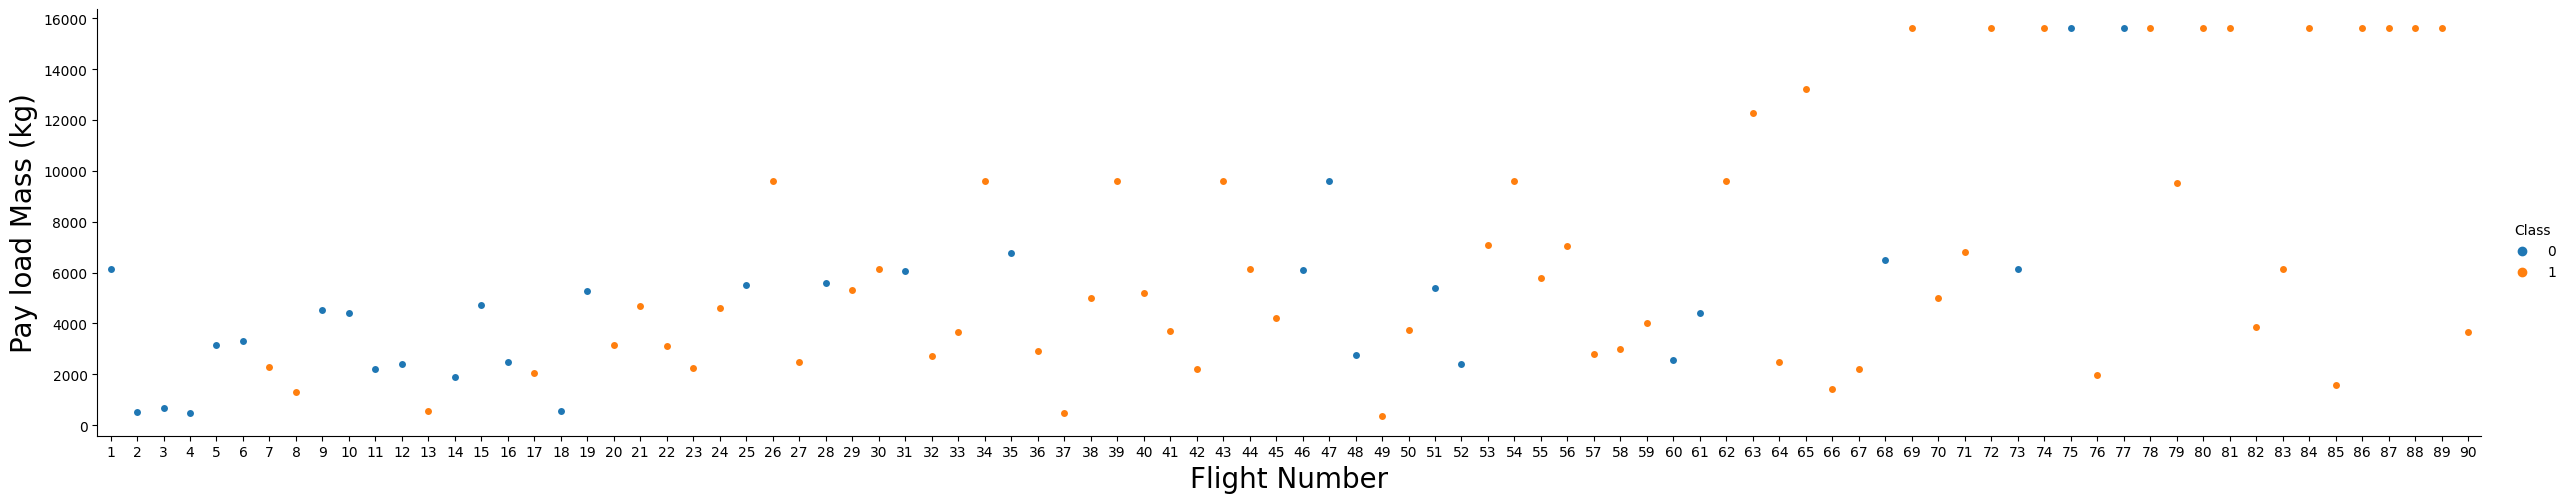

In [90]:
sns.catplot(y="PayloadMass", x="FlightNumber", hue="Class", data=df, aspect = 5)
plt.xlabel("Flight Number",fontsize=20)
plt.ylabel("Pay load Mass (kg)",fontsize=20)
plt.show()

We can see above that as flights occured (left to right), they got more successful outcomes.

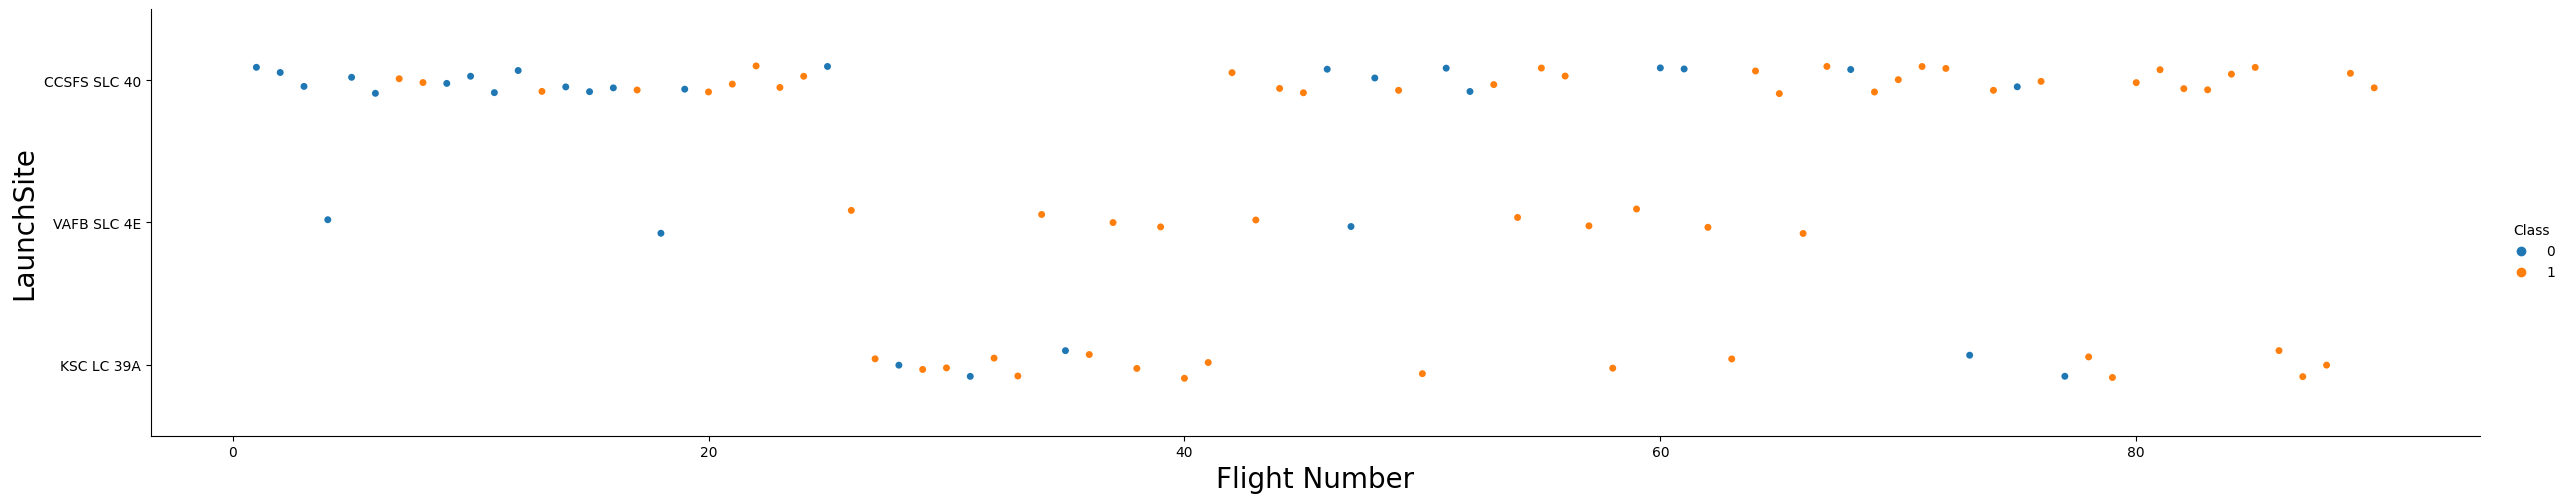

In [91]:
sns.catplot(y="LaunchSite", x="FlightNumber", hue="Class", data=df, aspect = 5)
plt.xlabel("Flight Number",fontsize=20)
plt.ylabel("LaunchSite",fontsize=20)
plt.show()

We can see that most of the failed outcomes happened in the CCSFS SLC 40 launch site, which is not surprising, since it was the one with more flights.

C:\Users\Yuri Faleiro\AppData\Local\Temp\ipykernel_4892\1154272287.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  mean = df.groupby(["Orbit"]).mean().reset_index()


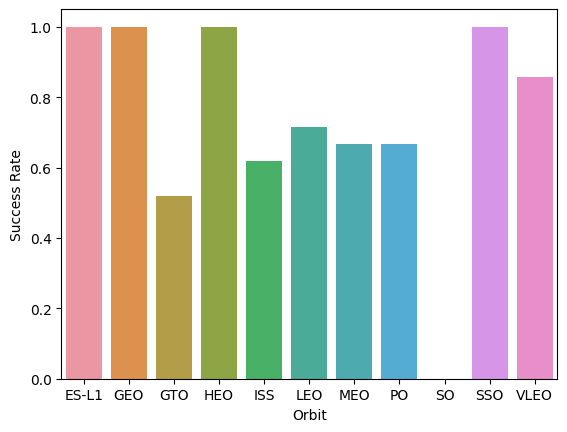

In [92]:
mean = df.groupby(["Orbit"]).mean().reset_index()
mean2 = mean[["Orbit", "Class"]]
sns.barplot(x="Orbit", y="Class", data=mean2)
plt.ylabel("Success Rate")
plt.show()

ES-L1, GEO, HEO and SSO Orbits had the highest success rates.

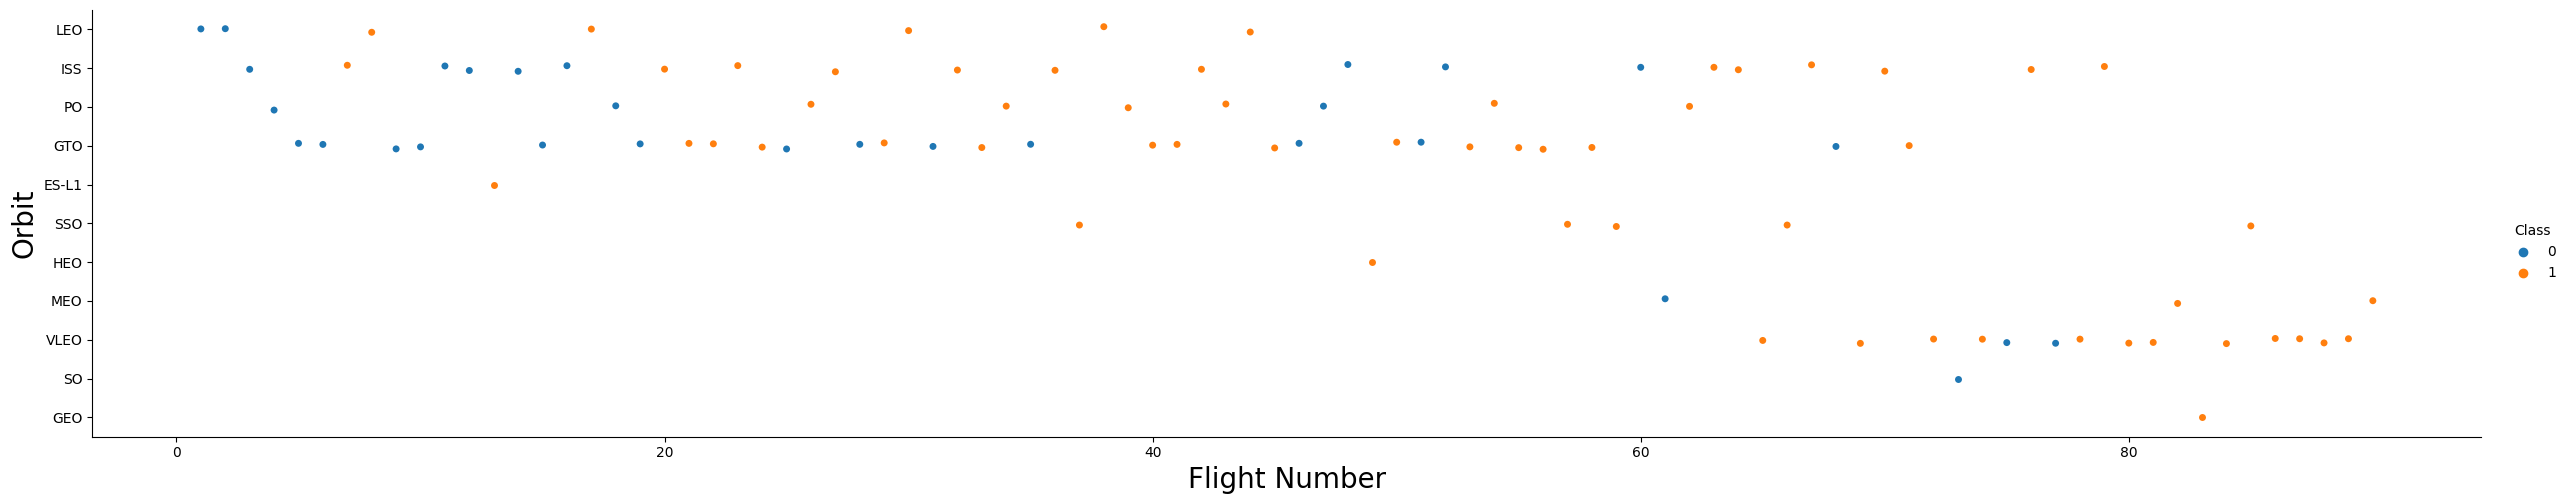

In [93]:
sns.catplot(y="Orbit", x="FlightNumber", hue="Class", data=df, aspect = 5)
plt.xlabel("Flight Number",fontsize=20)
plt.ylabel("Orbit",fontsize=20)
plt.show()

We can see that in the LEO orbit the Success appears related to the number of flights; on the other hand, there seems to be no relationship between flight number when in GTO orbit.

In [94]:
# A function to Extract years from the date 
df['Date'] = pd.to_datetime(df['Date'])
year = df['Date'].dt.year
year

C:\Users\Yuri Faleiro\AppData\Local\Temp\ipykernel_4892\3139714443.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Date'] = pd.to_datetime(df['Date'])


4     2010
5     2012
6     2013
7     2013
8     2013
      ... 
89    2020
90    2020
91    2020
92    2020
93    2020
Name: Date, Length: 90, dtype: int64

C:\Users\Yuri Faleiro\AppData\Local\Temp\ipykernel_4892\868666509.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["year"] = year
C:\Users\Yuri Faleiro\AppData\Local\Temp\ipykernel_4892\868666509.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Success Rate"] = df["Class"]


<AxesSubplot: xlabel='year', ylabel='Success Rate'>

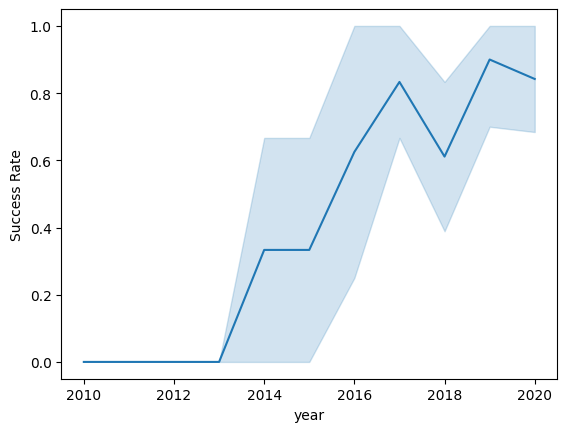

In [95]:
df["year"] = year
df["Success Rate"] = df["Class"]
sns.lineplot(data = df, x = "year", y = "Success Rate")

The success rate started to increase in 2013.

In [96]:
# After the data analysis is time for us to choose which features will be used in the model development section
features = df[['FlightNumber', 'PayloadMass', 'Orbit', 'LaunchSite', 'Flights', 'GridFins', 'Reused', 'Legs', 'LandingPad', 'Block', 'ReusedCount', 'Serial']]
features.head()

,FlightNumber,PayloadMass,Orbit,LaunchSite,Flights,GridFins,Reused,Legs,LandingPad,Block,ReusedCount,Serial
4,1,6123.547647,LEO,CCSFS SLC 40,1,False,False,False,None,1.0,0,B0003
5,2,525.000000,LEO,CCSFS SLC 40,1,False,False,False,None,1.0,0,B0005
6,3,677.000000,ISS,CCSFS SLC 40,1,False,False,False,None,1.0,0,B0007
7,4,500.000000,PO,VAFB SLC 4E,1,False,False,False,None,1.0,0,B1003
8,5,3170.000000,GTO,CCSFS SLC 40,1,False,False,False,None,1.0,0,B1004


### Task 5: Creating dummy variables to categorical columns

In [97]:
oh_orbit = pd.get_dummies(features["Orbit"])
oh_launch = pd.get_dummies(features["LaunchSite"])
oh_landing = pd.get_dummies(features["LandingPad"])
oh_serial = pd.get_dummies(features["Serial"])
remainder = features[["FlightNumber","PayloadMass", "Flights", "GridFins", "Reused", "Legs", "Block","ReusedCount"]]
features_one_hot = pd.concat([remainder, oh_launch, oh_landing, oh_serial, oh_orbit], axis=1)
features_one_hot.head()

,FlightNumber,PayloadMass,Flights,GridFins,Reused,Legs,Block,ReusedCount,CCSFS SLC 40,KSC LC 39A,VAFB SLC 4E,5e9e3032383ecb267a34e7c7,5e9e3032383ecb554034e7c9,5e9e3032383ecb6bb234e7ca,5e9e3032383ecb761634e7cb,5e9e3033383ecbb9e534e7cc,B0003,B0005,B0007,B1003,B1004,B1005,B1006,B1007,B1008,B1010,B1011,B1012,B1013,B1015,B1016,B1017,B1018,B1019,B1020,B1021,B1022,B1023,B1025,B1026,B1028,B1029,B1030,B1031,B1032,B1034,B1035,B1036,B1037,B1038,B1039,B1040,B1041,B1042,B1043,B1044,B1045,B1046,B1047,B1048,B1049,B1050,B1051,B1054,B1056,B1058,B1059,B1060,B1062,ES-L1,GEO,GTO,HEO,ISS,LEO,MEO,PO,SO,SSO,VLEO
4,1,6123.547647,1,False,False,False,1.0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
5,2,525.000000,1,False,False,False,1.0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
6,3,677.000000,1,False,False,False,1.0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
7,4,500.000000,1,False,False,False,1.0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
8,5,3170.000000,1,False,False,False,1.0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0


In [98]:
features_one_hot.astype('float64')

,FlightNumber,PayloadMass,Flights,GridFins,Reused,Legs,Block,ReusedCount,CCSFS SLC 40,KSC LC 39A,VAFB SLC 4E,5e9e3032383ecb267a34e7c7,5e9e3032383ecb554034e7c9,5e9e3032383ecb6bb234e7ca,5e9e3032383ecb761634e7cb,5e9e3033383ecbb9e534e7cc,B0003,B0005,B0007,B1003,B1004,B1005,B1006,B1007,B1008,B1010,B1011,B1012,B1013,B1015,B1016,B1017,B1018,B1019,B1020,B1021,B1022,B1023,B1025,B1026,B1028,B1029,B1030,B1031,B1032,B1034,B1035,B1036,B1037,B1038,B1039,B1040,B1041,B1042,B1043,B1044,B1045,B1046,B1047,B1048,B1049,B1050,B1051,B1054,B1056,B1058,B1059,B1060,B1062,ES-L1,GEO,GTO,HEO,ISS,LEO,MEO,PO,SO,SSO,VLEO
4,1.0,6123.547647,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
5,2.0,525.000000,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
6,3.0,677.000000,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
7,4.0,500.000000,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
8,5.0,3170.000000,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89,86.0,15600.000000,2.0,1.0,1.0,1.0,5.0,12.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
90,87.0,15600.000000,3.0,1.0,1.0,1.0,5.0,13.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
91,88.0,15600.000000,6.0,1.0,1.0,1.0,5.0,12.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
92,89.0,15600.000000,3.0,1.0,1.0,1.0,5.0,12.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


## Section 4: Model Development

This function is to plot the confusion matrix.


In [110]:
def plot_confusion_matrix(y,y_predict):
    "this function plots the confusion matrix"
    from sklearn.metrics import confusion_matrix

    cm = confusion_matrix(y, y_predict)
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax); #annot=True to annotate cells
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    ax.set_title('Confusion Matrix'); 
    ax.xaxis.set_ticklabels(['did not land', 'land']); ax.yaxis.set_ticklabels(['did not land', 'landed'])

### Task 6: Assigning variables X and Y


Create a NumPy array from the column <code>Class</code> in <code>data</code>, by applying the method <code>to_numpy()</code>  then
assign it  to the variable <code>Y</code>,make sure the output is a  Pandas series (only one bracket df\['name of  column']).


In [99]:
X = features_one_hot
Y = df["Class"].to_numpy()
Y

array([0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1,
       1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1,
       1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1], dtype=int64)

Standardize the data in <code>X</code> then reassign it to the variable  <code>X</code>


In [100]:
transform = preprocessing.StandardScaler()
xtransf = transform.fit_transform(X)
X = pd.DataFrame(xtransf)
X.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79
0,-1.712912,0.000000,-0.653913,-1.870829,-0.835532,-1.933091,-1.575895,-0.764529,0.797724,-0.568796,-0.410891,-0.410891,-0.150756,-0.797724,-0.150756,-0.392232,9.433981,-0.106000,-0.106000,-0.106000,-0.106000,-0.106,-0.106,-0.106,-0.106,-0.106,-0.106,-0.106,-0.106,-0.106,-0.106,-0.106,-0.106,-0.106,-0.106,-0.150756,-0.106,-0.106,-0.106,-0.106,-0.106,-0.150756,-0.106,-0.150756,-0.150756,-0.106,-0.150756,-0.150756,-0.106,-0.106,-0.150756,-0.150756,-0.150756,-0.106,-0.106,-0.106,-0.150756,-0.215666,-0.185695,-0.215666,-0.267261,-0.106,-0.242536,-0.106,-0.215666,-0.185695,-0.215666,-0.185695,-0.106,-0.106,-0.106,-0.654654,-0.106,-0.551677,3.443420,-0.185695,-0.333333,-0.106,-0.242536,-0.429198
1,-1.674419,-1.189724,-0.653913,-1.870829,-0.835532,-1.933091,-1.575895,-0.764529,0.797724,-0.568796,-0.410891,-0.410891,-0.150756,-0.797724,-0.150756,-0.392232,-0.106000,9.433981,-0.106000,-0.106000,-0.106000,-0.106,-0.106,-0.106,-0.106,-0.106,-0.106,-0.106,-0.106,-0.106,-0.106,-0.106,-0.106,-0.106,-0.106,-0.150756,-0.106,-0.106,-0.106,-0.106,-0.106,-0.150756,-0.106,-0.150756,-0.150756,-0.106,-0.150756,-0.150756,-0.106,-0.106,-0.150756,-0.150756,-0.150756,-0.106,-0.106,-0.106,-0.150756,-0.215666,-0.185695,-0.215666,-0.267261,-0.106,-0.242536,-0.106,-0.215666,-0.185695,-0.215666,-0.185695,-0.106,-0.106,-0.106,-0.654654,-0.106,-0.551677,3.443420,-0.185695,-0.333333,-0.106,-0.242536,-0.429198
2,-1.635927,-1.157423,-0.653913,-1.870829,-0.835532,-1.933091,-1.575895,-0.764529,0.797724,-0.568796,-0.410891,-0.410891,-0.150756,-0.797724,-0.150756,-0.392232,-0.106000,-0.106000,9.433981,-0.106000,-0.106000,-0.106,-0.106,-0.106,-0.106,-0.106,-0.106,-0.106,-0.106,-0.106,-0.106,-0.106,-0.106,-0.106,-0.106,-0.150756,-0.106,-0.106,-0.106,-0.106,-0.106,-0.150756,-0.106,-0.150756,-0.150756,-0.106,-0.150756,-0.150756,-0.106,-0.106,-0.150756,-0.150756,-0.150756,-0.106,-0.106,-0.106,-0.150756,-0.215666,-0.185695,-0.215666,-0.267261,-0.106,-0.242536,-0.106,-0.215666,-0.185695,-0.215666,-0.185695,-0.106,-0.106,-0.106,-0.654654,-0.106,1.812654,-0.290409,-0.185695,-0.333333,-0.106,-0.242536,-0.429198
3,-1.597434,-1.195037,-0.653913,-1.870829,-0.835532,-1.933091,-1.575895,-0.764529,-1.253566,-0.568796,2.433737,-0.410891,-0.150756,-0.797724,-0.150756,-0.392232,-0.106000,-0.106000,-0.106000,9.433981,-0.106000,-0.106,-0.106,-0.106,-0.106,-0.106,-0.106,-0.106,-0.106,-0.106,-0.106,-0.106,-0.106,-0.106,-0.106,-0.150756,-0.106,-0.106,-0.106,-0.106,-0.106,-0.150756,-0.106,-0.150756,-0.150756,-0.106,-0.150756,-0.150756,-0.106,-0.106,-0.150756,-0.150756,-0.150756,-0.106,-0.106,-0.106,-0.150756,-0.215666,-0.185695,-0.215666,-0.267261,-0.106,-0.242536,-0.106,-0.215666,-0.185695,-0.215666,-0.185695,-0.106,-0.106,-0.106,-0.654654,-0.106,-0.551677,-0.290409,-0.185695,3.000000,-0.106,-0.242536,-0.429198
4,-1.558942,-0.627646,-0.653913,-1.870829,-0.835532,-1.933091,-1.575895,-0.764529,0.797724,-0.568796,-0.410891,-0.410891,-0.150756,-0.797724,-0.150756,-0.392232,-0.106000,-0.106000,-0.106000,-0.106000,9.433981,-0.106,-0.106,-0.106,-0.106,-0.106,-0.106,-0.106,-0.106,-0.106,-0.106,-0.106,-0.106,-0.106,-0.106,-0.150756,-0.106,-0.106,-0.106,-0.106,-0.106,-0.150756,-0.106,-0.150756,-0.150756,-0.106,-0.150756,-0.150756,-0.106,-0.106,-0.150756,-0.150756,-0.150756,-0.106,-0.106,-0.106,-0.150756,-0.215666,-0.185695,-0.215666,-0.267261,-0.106,-0.242536,-0.106,-0.215666,-0.185695,-0.215666,-0.185695,-0.106,-0.106,-0.106,1.527525,-0.106,-0.551677,-0.290409,-0.185695,-0.333333,-0.106,-0.242536,-0.429198


We split the data into training and testing data using the  function  <code>train_test_split</code>.   The training data is divided into validation data, a second set used for training  data; then the models are trained and hyperparameters are selected using the function <code>GridSearchCV</code>.


In [103]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=2)
Y_test.shape

(18,)

## Task 7: Creating a logistic regression model

We create a logistic regression object  then create a  GridSearchCV object  <code>logreg_cv</code> with cv = 10, then fit the object to find the best parameters from the dictionary <code>parameters</code>.


In [104]:
parameters ={'C':[0.01,0.1,1],
             'penalty':['l2'],
             'solver':['lbfgs']}

In [106]:
parameters ={"C":[0.01,0.1,1],'penalty':['l2'], 'solver':['lbfgs']}# l1 lasso l2 ridge
lr=LogisticRegression()
logreg_cv = GridSearchCV(lr, parameters, cv=10)
logreg_cv.fit(X_train, Y_train)

GridSearchCV(cv=10, estimator=LogisticRegression(),
             param_grid={'C': [0.01, 0.1, 1], 'penalty': ['l2'],
                         'solver': ['lbfgs']})

We output the <code>GridSearchCV</code> object for logistic regression. We display the best parameters using the data attribute <code>best_params\_</code> and the accuracy on the validation data using the data attribute <code>best_score\_</code>.


In [107]:
print("tuned hpyerparameters :(best parameters) ",logreg_cv.best_params_)
print("accuracy :",logreg_cv.best_score_)

tuned hpyerparameters :(best parameters)  {'C': 0.1, 'penalty': 'l2', 'solver': 'lbfgs'}
accuracy : 0.8214285714285714


After this, we calculate the accuracy on the test data using the method <code>score</code>:


In [108]:
logreg_cv.score(X_test, Y_test)

0.8333333333333334

Finally, we plot the confusion matrix


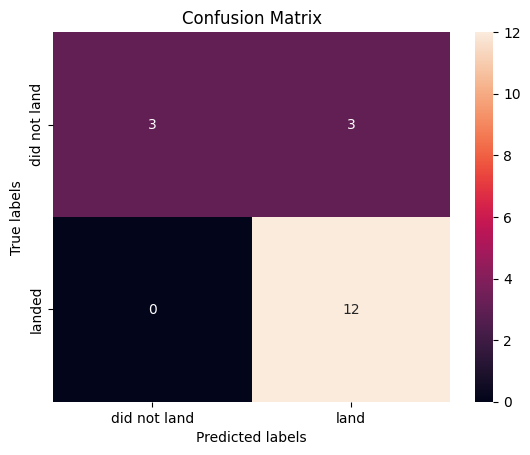

In [111]:
yhat=logreg_cv.predict(X_test)
plot_confusion_matrix(Y_test,yhat)
plt.show()

Examining the confusion matrix, we see that logistic regression can distinguish between the different classes.  We see that the major problem is false positives, meaning the upper right block, which predicted 3 (50%) wrong labels.


## Task 8: Repeating last task with 3 other types of models


In [112]:
parameters = {'kernel':('linear', 'rbf','poly','rbf', 'sigmoid'),
              'C': np.logspace(-3, 3, 5),
              'gamma':np.logspace(-3, 3, 5)}
svm = SVC()

In [113]:
svm_cv = GridSearchCV(svm, parameters, cv = 10)
svm_cv.fit(X_train, Y_train)

GridSearchCV(cv=10, estimator=SVC(),
             param_grid={'C': array([1.00000000e-03, 3.16227766e-02, 1.00000000e+00, 3.16227766e+01,
       1.00000000e+03]),
                         'gamma': array([1.00000000e-03, 3.16227766e-02, 1.00000000e+00, 3.16227766e+01,
       1.00000000e+03]),
                         'kernel': ('linear', 'rbf', 'poly', 'rbf', 'sigmoid')})

In [114]:
print("tuned hpyerparameters :(best parameters) ",svm_cv.best_params_)
print("accuracy :",svm_cv.best_score_)

tuned hpyerparameters :(best parameters)  {'C': 1.0, 'gamma': 0.03162277660168379, 'kernel': 'sigmoid'}
accuracy : 0.8482142857142858


In [115]:
svm_cv.score(X_test, Y_test)

0.8333333333333334

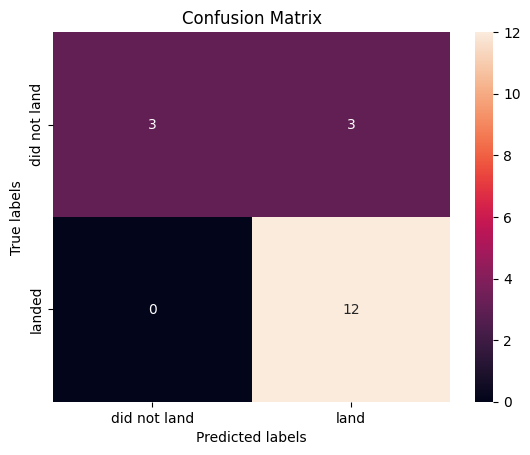

In [116]:
yhat=svm_cv.predict(X_test)
plot_confusion_matrix(Y_test,yhat)
plt.show()

In [117]:
parameters = {'criterion': ['gini', 'entropy'],
     'splitter': ['best', 'random'],
     'max_depth': [2*n for n in range(1,10)],
     'max_features': ['auto', 'sqrt'],
     'min_samples_leaf': [1, 2, 4],
     'min_samples_split': [2, 5, 10]}

tree = DecisionTreeClassifier()

In [119]:
tree_cv = GridSearchCV(tree, parameters, cv = 10)
tree_cv.fit(X_train, Y_train)

C:\Users\Yuri Faleiro\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\tree\_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
C:\Users\Yuri Faleiro\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\tree\_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
C:\Users\Yuri Faleiro\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\tree\_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, ex

GridSearchCV(cv=10, estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [2, 4, 6, 8, 10, 12, 14, 16, 18],
                         'max_features': ['auto', 'sqrt'],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'splitter': ['best', 'random']})

In [120]:
print("tuned hpyerparameters :(best parameters) ",tree_cv.best_params_)
print("accuracy :",tree_cv.best_score_)

tuned hpyerparameters :(best parameters)  {'criterion': 'entropy', 'max_depth': 8, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 10, 'splitter': 'random'}
accuracy : 0.8875


In [121]:
tree_cv.score(X_test, Y_test)

0.7777777777777778

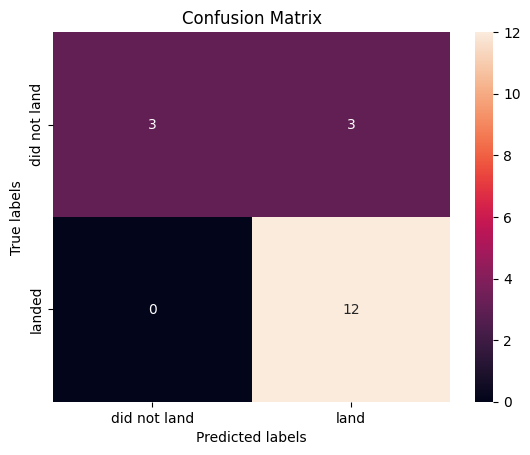

In [122]:
yhat = svm_cv.predict(X_test)
plot_confusion_matrix(Y_test,yhat)
plt.show()

In [123]:
parameters = {'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
              'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
              'p': [1,2]}

KNN = KNeighborsClassifier()

In [124]:
knn_cv = GridSearchCV(KNN, parameters, cv=10)
knn_cv.fit(X_train, Y_train)

GridSearchCV(cv=10, estimator=KNeighborsClassifier(),
             param_grid={'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
                         'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
                         'p': [1, 2]})

In [125]:
print("tuned hpyerparameters :(best parameters) ",knn_cv.best_params_)
print("accuracy :",knn_cv.best_score_)

tuned hpyerparameters :(best parameters)  {'algorithm': 'auto', 'n_neighbors': 3, 'p': 1}
accuracy : 0.8339285714285714


In [126]:
knn_cv.score(X_test, Y_test)

0.7777777777777778

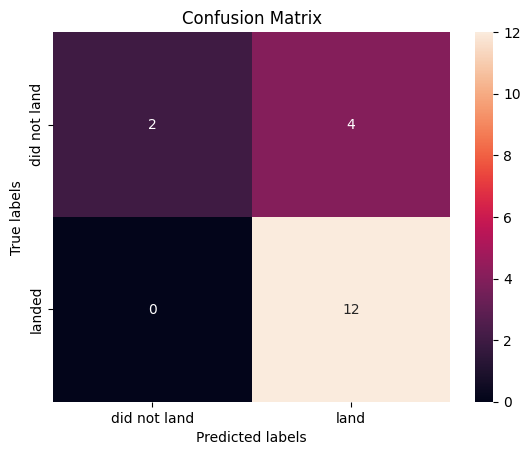

In [127]:
yhat = knn_cv.predict(X_test)
plot_confusion_matrix(Y_test,yhat)
plt.show()

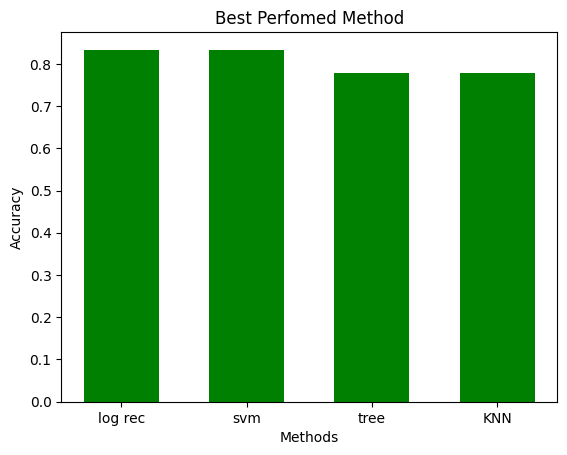

In [128]:
accuracy=[]
method=[]
accuracy.append(logreg_cv.score(X_test, Y_test))
method.append("log rec")
accuracy.append(svm_cv.score(X_test, Y_test))
method.append("svm")
accuracy.append(tree_cv.score(X_test, Y_test))
method.append("tree")
accuracy.append(knn_cv.score(X_test, Y_test))
method.append("KNN")

import numpy as np
import matplotlib.pyplot as plt

plt.bar(method, accuracy, color='green', width=0.6)
plt.xlabel("Methods")
plt.ylabel("Accuracy")
plt.title("Best Perfomed Method")
plt.show()

We now see that both the logistic regression and support vector machine model had the same accuracy. So both can be used for a competitor to predict the landing outcome of the Stage 1 part of the rocket with a fairly high accuracy. Obviously, this wouldn't be the final model, we would deploy it, get feedback and then tune it, make adjustments to better fit the model for the needs of the user.